In [133]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric as tgn
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
import torch.nn.functional as F

from torch_geometric.loader import DataLoader

from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

from tqdm import tqdm

# Model Definition

In [165]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(2, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

# Training and Helper Methods

In [192]:
def train_one_epoch(model, data_loader, optimizer, loss_fn):
    
    for _, batch in enumerate(data_loader):
        optimizer.zero_grad()
        model_out = model(batch.x.float(), batch.edge_index, batch.batch)
        # loss = loss_fn(torch.squeeze(model_out), batch.y.float())
        loss = loss_fn(model_out, batch.y)

        loss.backward()  
        optimizer.step()
    
    return loss
    

In [193]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [203]:
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x.float(), data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

# Message Passing Pyg Experiments

In [214]:
rich_data = np.fromfile('dataset.dat')

In [195]:
# data_list = torch.load('tensor_list.pt')

data_list = torch.load('tensor_list_node_labels.pt')

In [204]:
train_loader = DataLoader(data_list[:int(len(data_list)*0.9)], batch_size=32, shuffle=True)
test_loader = DataLoader(data_list[:int(len(data_list)*0.9)], batch_size=32, shuffle=True)

In [205]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss() 
# *** NOTE on loss function *** I think Cross Entropy Loss requires a different output channel for each class ***

In [206]:
epochs = 50

model.train()

losses = []
test_scores = []
pbar = tqdm(total = epochs, position=0, leave=True)
for epoch in range(epochs):
    losses.append(train_one_epoch(model, train_loader, optimizer, loss_fn))
    test_scores.append(test(test_loader))
    pbar.update(1)
pbar.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:06<00:00,  2.52s/it]


In [207]:
GCN_losses = losses

In [209]:
test_scores

[0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845146598,
 0.6337887845

  0%|                                                                                                      | 0/50 [03:17<?, ?it/s]


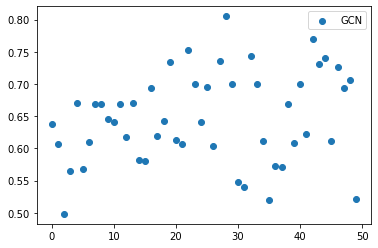

In [208]:
epochs = len(GCN_losses)
y = [item.detach().numpy() for item in GCN_losses]


plt.scatter(range(epochs), y, label='GCN')
plt.legend()

In [89]:
data_i = iter(loader).next()[0]

In [94]:
data_i.x.shape

torch.Size([28, 2])

In [98]:
data_i.y

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], dtype=torch.float64)

In [107]:
pred(model, data_i.x.float(), data_i.edge_index)

tensor([1])

In [117]:
sub_data = data_list

runs = 0
correct = 0
for data_i in sub_data:
    label = data_i.y[0]
    
    data_i.edge_index
    predict = pred(model, data_i.x.float(), data_i.edge_index)
    
    runs += 1
    if label == predict:
        correct += 1

print('accuracy: ', correct/runs)

accuracy:  0.6345587293454592


### EdgeConv

In [132]:
model = EdgeConv(2,1)
print('num model params:', count_parameters(model))
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

num model params: 7


In [131]:
epochs = 100

model.train()
for epoch in range(epochs):
    loss = train_one_epoch(model, loader, optimizer, loss_fn)

/Users/maxperozek/opt/anaconda3/envs/comp_gr_thy/lib/python3.9/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([818])) that is different to the input size (torch.Size([818, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (2) must match the size of tensor b (818) at non-singleton dimension 1

In [125]:
loss

tensor(0.2825, grad_fn=<MseLossBackward0>)

In [63]:
from torch.nn import Softmax

In [65]:
m = Softmax(dim=1)
inp = torch.randn(2, 3)
output = m(inp)

In [66]:
output

tensor([[0.6567, 0.1431, 0.2002],
        [0.1342, 0.6416, 0.2242]])

In [67]:
inp

tensor([[ 0.2658, -1.2583, -0.9221],
        [ 0.8187,  2.3836,  1.3323]])